In [1]:
from pathlib import Path
import pandas as pd
from pandas import DataFrame, MultiIndex, merge, read_csv, concat
import seaborn as sns

from reservoirs_synthetic_bph.utils.data import get_dataframe, remove_warmup_df
from reservoirs_synthetic_bph.utils.global_config import (
    N_WARMUPS,
    SERIES,
    TSTEPS,
    DATA_DIR,
    TEST_FILE,
    METRIC_CSV_FILE,
)
from reservoirs_synthetic_bph.utils.post_processing import (
    METRIC,
    DSET,
    TGT,
    VAL,
    SIMS,
    SERIES as INDIV,
    TSTEPS,
    PRED,
)

MDL = "model"
METD = "method"
SPEC = "spec."
NOISE = "w/ noise"
NONOISE = "w/o noise"

Data folder: /home/francois/Documents/SISTM/subSISTM/data/synthetic_bph_1


In [151]:
def generate_display(
    df: pd.DataFrame, metric: str, effect: str, column_order: list = None
):
    # we use pivot to make sur that there's a single value for each case
    # pivot_table use aggregating and will return a value instead of raising an error

    idxs = [MDL, SPEC]
    cols = [DSET, TGT]

    if METD in df.columns:
        cols = [METD] + cols

    df = df[df[METRIC] == metric]
    assert len(df) > 0

    df = df[df[DSET].str.endswith(effect)]
    assert len(df) > 0

    df = (
        df.pivot(
            index=idxs,
            columns=cols,
            values=[VAL],
        )
        .droplevel(level=0, axis=1)
        .sort_index(level=0, axis=1, ascending=False)
    )

    if column_order:
        # !!! NaN values means that the given indices
        df = df.reindex(columns=pd.MultiIndex.from_product(column_order))

    stlr = df.style
    stlr.format("{:#.2g}")
    # use df.to_html() to find the CSS labels
    stlr.set_table_styles(
        [
            {
                "selector": "table, th, td",
                "props": "border: 1px solid; text-align: center",
            },
        ]
    )
    # stlr.background_gradient(axis=0)
    return stlr


def base_convert_name(name, conversion_list):
    result = [nc for nc in conversion_list if name in nc[1]]
    assert len(result) == 1, name
    return result[0][0]

# Test results

In [3]:
test_pred = read_csv(
    DATA_DIR + "/01_test.csv", sep=";", decimal=",", index_col=[INDIV, TSTEPS]
)[["y_fixed", "y_mixed"]]
test_pred = test_pred.melt(ignore_index=False)
test_pred = test_pred.rename(columns={"variable": DSET})
test_pred[DSET] = test_pred[DSET].replace(
    {"y_fixed": "test-fixed", "y_mixed": "test-mixed"}
)
test_pred = test_pred.set_index([DSET], append=True)
test_pred = test_pred.reorder_levels([DSET, INDIV, TSTEPS], axis=0)
test_pred

value
dataset    individus temps           
test-fixed 1         0     -10.270811
                     1      -9.577035
                     2      -9.241133
                     3      -9.046099
                     4      -8.925675
...                               ...
test-mixed 500       21     14.255805
                     22     14.365780
                     23     14.480369
                     24     14.599297
                     25     14.722291

[26000 rows x 1 columns]

# Arthur's results

In [4]:
# put a comma at the end of a single value tuple


def arthur_convert_name(name):
    names_conversions = [
        (
            ("Linear model", "x1+…+x8"),
            ("lin_simple_fixed",),
        ),
        (
            ("Linear model", "x2*x5+x4*x7+x6*x8"),
            ("fixed",),
        ),
        (
            ("Mixed model", "x2*x5+x4*x7+x6*x8"),
            ("mixed",),
        ),
        (
            ("Mixed model", "x1+…+x8"),
            ("lin_mixed", "lin_fixed"),
        ),
        (
            ("Mixed model", "t^1+…+t^4"),
            ("naif_fixed", "naif_mixed"),
        ),
    ]
    return base_convert_name(name, names_conversions)

## Metrics

In [5]:
arthur_metrics = pd.read_csv(
    DATA_DIR + "/Résultats/Performances_moyennes.csv", index_col=0
).drop(
    columns=["mse_test_fixed_obs.1"]
)  # I've checked: it a duplicate
# there is also "Résultats simulation.csv" with MSE/MAE for each simulation


def split_names(c: str) -> dict[str, str]:
    splt = c.split("_")
    model_ = "_".join(splt[2:-1])
    model, spec = arthur_convert_name(model_)
    return {
        METRIC: splt[0],
        DSET: f"{splt[1]}-{splt[-2]}",
        MDL: model,
        SPEC: spec,
        TGT: splt[-1],
    }


arthur_metrics = pd.DataFrame(
    [
        {**split_names(col), VAL: arthur_metrics[col].iloc[0]}
        for col in arthur_metrics.columns
    ]
)

arthur_metrics["target"] = arthur_metrics["target"].replace(
    {"truth": NONOISE, "obs": NOISE, "obs.1": NOISE}
)
arthur_metrics

,metric,dataset,model,spec.,target,value
0,mae,train-mixed,Mixed model,x2*x5+x4*x7+x6*x8,w/o noise,0.211769
1,mse,train-mixed,Mixed model,x2*x5+x4*x7+x6*x8,w/o noise,0.084689
2,mae,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,w/o noise,0.209960
3,mse,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,w/o noise,0.084497
4,mae,train-mixed,Mixed model,t^1+…+t^4,w/o noise,1.480595
5,mse,train-mixed,Mixed model,t^1+…+t^4,w/o noise,8.234363
6,mae,test-mixed,Mixed model,t^1+…+t^4,w/o noise,1.434460
7,mse,test-mixed,Mixed model,t^1+…+t^4,w/o noise,8.285175
8,mae,train-mixed,Mixed model,x2*x5+x4*x7+x6*x8,w/ noise,0.760418
9,mse,train-mixed,Mixed model,x2*x5+x4*x7+x6*x8,w/ noise,0.915951


In [6]:
# generate_display(arthur_metrics, metric="mse", effect="fixed")

In [7]:
# generate_display(arthur_metrics, metric="mse", effect="mixed")

## Predictions

Arthur's prediction are the ones made on the test dataset with the models trained on the different simulations.

In [175]:
arthur_preds = pd.read_csv(
    DATA_DIR + "/Résultats/Predictions.csv.gz", index_col=[INDIV, TSTEPS]
)
arthur_preds = arthur_preds.drop(columns=["Unnamed: 0"])
arthur_preds = arthur_preds.melt(ignore_index=False)

arthur_preds = arthur_preds.rename(columns={"variable": SIMS})
arthur_preds[SIMS] = arthur_preds[SIMS].str.replace(r"^pred_", r"", regex=True)

tmp = (
    arthur_preds[SIMS].str.replace(r"_\d+$", r"", regex=True).apply(arthur_convert_name)
)
arthur_preds[MDL] = tmp.apply(lambda x: x[0])
arthur_preds[SPEC] = tmp.apply(lambda x: x[1])


def get_effect(x):
    for effect in ["mixed", "fixed"]:
        if effect in x:
            return effect
    raise UserWarning()


arthur_preds[DSET] = "test-" + arthur_preds[SIMS].apply(get_effect)
arthur_preds[SIMS] = arthur_preds[SIMS].str.replace(
    r"^.*_(\d+)", r"simulation\1.csv", regex=True
)

arthur_preds = arthur_preds.set_index(SIMS, append=True)
arthur_preds = arthur_preds.set_index(MDL, append=True)
arthur_preds = arthur_preds.set_index(SPEC, append=True)
arthur_preds = arthur_preds.set_index(DSET, append=True)
arthur_preds = arthur_preds.reorder_levels([DSET, MDL, SPEC, SIMS, INDIV, TSTEPS])

arthur_preds = arthur_preds.rename(columns={"value": PRED})
arthur_preds

pred
dataset    model       spec.             simulation        individus temps           
test-mixed Mixed model x2*x5+x4*x7+x6*x8 simulation1.csv   1         0     -14.825990
                                                                     1     -13.545691
                                                                     2     -12.922801
                                                                     3     -12.592934
                                                                     4     -12.406496
...                                                                               ...
test-fixed Mixed model t^1+…+t^4         simulation100.csv 500       21      2.911111
                                                                     22      3.158828
                                                                     23      3.406546
                                                                     24      3.654263
                                                                     25      3.901981

[9100000 rows x 1 columns]

# Results with a forecast method for the mixed model

The prediction of a mixed model normally uses the data at all timesteps.  

Here to predict the value for the timesteps $t0$ we only use the data of the previous steps.

Here's the corresponding R code:

```R
# initialization with the marginal predictions
pred <- as.vector(predictY(model, newdata = data, marg = TRUE)$pred)
for (t in temps[-1:-1]) {
# using only the previous time steps to predict the random effect
prev_data <- data[data[TSTEP] < t, ]
ui <- predictRE(model, prev_data)
# (some checks…)
# combining the marginal and the random effects prediction == subject specific
reffects <- ui$intercept + rowSums(data[data[TSTEP] == t, X_LABELS] * ui[, X_LABELS])
pred[data[TSTEP] == t] <- pred[data[TSTEP] == t] + reffects
}
```

In [9]:
# put a comma at the end of a single value tuple


def new_convert_name(name):
    names_conversions = [
        (
            ("Mixed model", "x2*x5+x4*x7+x6*x8"),
            ("mixed_oracle"),
        ),
        (
            ("Mixed model", "x1+…+x8"),
            ("mixed_linear", "fixed_linear"),
        ),
        (
            ("Mixed model", "t^1+…+t^4"),
            ("mixed_time-polynom", "fixed_time-polynom"),
        ),
    ]
    return base_convert_name(name, names_conversions)

## Metrics

In [10]:
new_metrics = pd.DataFrame()
for pth in Path("mixed_model_forecast").rglob("*csv"):
    model = str(pth).split("/")[1]
    tmp = pd.read_csv(pth, index_col=0)
    tmp[MDL] = model
    new_metrics = pd.concat([new_metrics, tmp])


def new_restructure_row(row):
    try:
        if row[TGT].endswith("_obs"):
            tgt = NOISE
        else:
            tgt = NONOISE
    except AttributeError:
        tgt = row[TGT]

    dset = row[DSET] + "-" + row[MDL].split("_")[0]
    mdl = new_convert_name(row[MDL])
    met = (
        row[METRIC]
        .replace("mean_absolute_error", "mae")
        .replace("mean_squared_error", "mse")
    )

    row[DSET] = dset
    row[TGT] = tgt
    row[METRIC] = met
    row[MDL], row[SPEC] = mdl
    return row


new_metrics = new_metrics.apply(new_restructure_row, axis=1)
new_metrics

,dataset,target,metric,value,model,spec.
0,train-mixed,w/o noise,mae,0.316157,Mixed model,x2*x5+x4*x7+x6*x8
1,train-mixed,w/o noise,mse,0.175762,Mixed model,x2*x5+x4*x7+x6*x8
2,train-mixed,w/ noise,mae,0.863870,Mixed model,x2*x5+x4*x7+x6*x8
3,train-mixed,w/ noise,mse,1.174989,Mixed model,x2*x5+x4*x7+x6*x8
4,test-mixed,w/o noise,mae,0.313691,Mixed model,x2*x5+x4*x7+x6*x8
5,test-mixed,w/o noise,mse,0.173205,Mixed model,x2*x5+x4*x7+x6*x8
6,test-mixed,w/ noise,mae,0.856459,Mixed model,x2*x5+x4*x7+x6*x8
7,test-mixed,w/ noise,mse,1.157790,Mixed model,x2*x5+x4*x7+x6*x8
0,test-mixed,w/o noise,quad-bias,0.172845,Mixed model,x2*x5+x4*x7+x6*x8
1,test-mixed,w/ noise,quad-bias,1.157430,Mixed model,x2*x5+x4*x7+x6*x8


In [11]:
# generate_display(new_metrics, metric="mse", effect="fixed")

In [12]:
# generate_display(new_metrics, metric="mse", effect="mixed")

## Predictions

In [177]:
new_preds = pd.DataFrame()
for pth in Path("mixed_model_forecast").rglob("*gz"):
    model = str(pth).split("/")[1]
    tmp = pd.read_csv(pth, index_col=[SIMS, INDIV, TSTEPS])
    tmp[DSET] += f'-{model.split("_")[0]}'
    tmp[MDL], tmp[SPEC] = new_convert_name(model)
    tmp = tmp.set_index([DSET, MDL, SPEC], append=True)
    new_preds = pd.concat([new_preds, tmp])

new_preds = new_preds.reorder_levels([DSET, MDL, SPEC, SIMS, INDIV, TSTEPS])
new_preds

pred
dataset     model       spec.             simulation       individus temps           
train-mixed Mixed model x2*x5+x4*x7+x6*x8 simulation1.csv  1         0      -9.326291
                                                                     1      -5.139251
                                                                     2      -1.325299
                                                                     3      -0.093097
                                                                     4       0.368824
...                                                                               ...
test-mixed  Mixed model x1+…+x8           simulation99.csv 500       21     14.951400
                                                                     22     14.727796
                                                                     23     14.658540
                                                                     24     14.847263
                                                                     25     14.464328

[13000000 rows x 1 columns]

# Reservoirs results

In [14]:
# put a comma at the end of a single value tuple


def reservoir_convert_name(name):
    names_conversions = [
        (
            ("Reservoir model", "x2*x5+x4*x7+x6*x8"),
            ("mixed_oracle", "fixed_oracle"),
        ),
        (
            ("Reservoir model", "x2*x5+x4*x7+x6*x8+y(t-1)"),
            ("mixed_oracle_y", "fixed_oracle_y"),
        ),
        (
            ("Reservoir model", "x1+…+x8"),
            ("mixed_naive", "fixed_naive"),
        ),
        (
            ("Reservoir model", "x1+…+x8+y(t-1)"),
            ("mixed_naive_y", "fixed_naive_y"),
        ),
    ]
    return base_convert_name(name, names_conversions)

## Metrics

In [15]:
reservoir_metrics = pd.DataFrame()
for pth in Path("reservoirs_synthetic_bph").rglob("metrics.csv"):
    model = str(pth).split("/")[1]
    tmp = pd.read_csv(pth, index_col=0)
    tmp[MDL] = model
    reservoir_metrics = pd.concat([reservoir_metrics, tmp])


def reservoir_restructure_row(row):
    try:
        if row[TGT].endswith("_obs"):
            tgt = NOISE
        else:
            tgt = NONOISE
    except AttributeError:
        tgt = row[TGT]

    effect = row[MDL].split("_")[0]
    dset = row[DSET] + "-" + effect
    mdl = reservoir_convert_name(row[MDL])
    met = (
        row[METRIC]
        .replace("mean_absolute_error", "mae")
        .replace("mean_squared_error", "mse")
    )

    row[DSET] = dset
    row[TGT] = tgt
    row[METRIC] = met
    row[MDL], row[SPEC] = mdl
    return row


reservoir_metrics = reservoir_metrics.apply(reservoir_restructure_row, axis=1)

reservoir_metrics

,dataset,target,metric,value,model,spec.
0,train-mixed,w/o noise,mae,0.606924,Reservoir model,x1+…+x8+y(t-1)
1,train-mixed,w/o noise,mse,0.614341,Reservoir model,x1+…+x8+y(t-1)
2,train-mixed,w/ noise,mae,1.006300,Reservoir model,x1+…+x8+y(t-1)
3,train-mixed,w/ noise,mse,1.608549,Reservoir model,x1+…+x8+y(t-1)
4,test-mixed,w/o noise,mae,0.629890,Reservoir model,x1+…+x8+y(t-1)
...,...,...,...,...,...,...
6,test-fixed,w/ noise,mae,0.793371,Reservoir model,x2*x5+x4*x7+x6*x8
7,test-fixed,w/ noise,mse,0.988440,Reservoir model,x2*x5+x4*x7+x6*x8
0,test-fixed,w/o noise,quad-bias,0.001858,Reservoir model,x2*x5+x4*x7+x6*x8
1,test-fixed,w/ noise,quad-bias,0.987029,Reservoir model,x2*x5+x4*x7+x6*x8


In [16]:
generate_display(reservoir_metrics, metric="mse", effect="fixed")

In [17]:
generate_display(reservoir_metrics, metric="mse", effect="mixed")

## Predictions

In [178]:
reservoir_preds = pd.DataFrame()
for pth in Path("reservoirs_synthetic_bph/").rglob("*gz"):
    model = str(pth).split("/")[1]
    tmp = pd.read_csv(pth, index_col=[SIMS, INDIV, TSTEPS])

    tmp[DSET] += f'-{model.split("_")[0]}'
    tmp[MDL], tmp[SPEC] = reservoir_convert_name(model)
    tmp = tmp.set_index([DSET, MDL, SPEC], append=True)
    assert len(tmp.columns) == 1
    tmp = tmp.rename(columns={tmp.columns[0]: PRED})
    #
    reservoir_preds = pd.concat([reservoir_preds, tmp])

reservoir_preds = reservoir_preds.reorder_levels([DSET, MDL, SPEC, SIMS, INDIV, TSTEPS])
reservoir_preds

pred
dataset     model           spec.             simulation       individus temps           
train-mixed Reservoir model x1+…+x8+y(t-1)    simulation71.csv 1         1     -17.183952
                                                                         2     -31.430326
                                                                         3     -27.641001
                                                                         4     -27.197520
                                                                         5     -31.973513
...                                                                                   ...
test-fixed  Reservoir model x2*x5+x4*x7+x6*x8 simulation50.csv 500       21      3.662564
                                                                         22      4.026796
                                                                         23      4.387312
                                                                         24      4.744256
                                                                         25      5.097816

[15400000 rows x 1 columns]

# Comparison between "fit" and "forecast" mixed model predictions.

## Metrics

In [119]:
copy_1 = arthur_metrics.copy()
copy_1[METD] = "fit"
copy_2 = new_metrics.copy()
copy_2[METD] = "forecast"


comp_df = pd.concat([copy_1, copy_2])
comp_df = comp_df.dropna(subset=[DSET])

In [120]:
comp_df

,metric,dataset,model,spec.,target,value,method
0,mae,train-mixed,Mixed model,x2*x5+x4*x7+x6*x8,w/o noise,0.211769,fit
1,mse,train-mixed,Mixed model,x2*x5+x4*x7+x6*x8,w/o noise,0.084689,fit
2,mae,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,w/o noise,0.209960,fit
3,mse,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,w/o noise,0.084497,fit
4,mae,train-mixed,Mixed model,t^1+…+t^4,w/o noise,1.480595,fit
...,...,...,...,...,...,...,...
6,mae,test-mixed,Mixed model,x1+…+x8,w/ noise,0.947409,forecast
7,mse,test-mixed,Mixed model,x1+…+x8,w/ noise,1.441431,forecast
0,quad-bias,test-mixed,Mixed model,x1+…+x8,w/o noise,0.446460,forecast
1,quad-bias,test-mixed,Mixed model,x1+…+x8,w/ noise,1.435904,forecast


In [152]:
generate_display(
    comp_df,
    metric="mse",
    effect="fixed",
    column_order=[
        ("fit", "forecast"),
        ("train-fixed", "test-fixed"),
        ("w/o noise", "w/ noise"),
    ],
)

In [155]:
generate_display(
    comp_df,
    metric="mse",
    effect="mixed",
    column_order=[
        ("fit", "forecast"),
        ("train-mixed", "test-mixed"),
        ("w/o noise", "w/ noise"),
    ],
)

## Predictions

In [179]:
copy_1 = arthur_preds.copy()
copy_1[METD] = "fit"
copy_2 = new_preds.copy()
copy_2[METD] = "forecast"

comp_df = pd.concat([copy_1, copy_2]).reset_index()

assert len(comp_df[DSET].unique()) == 4


comp_df = pd.merge(
    comp_df,
    test_pred.reset_index(),
    on=[DSET, INDIV, TSTEPS],
)

assert len(comp_df[DSET].unique()) == 2

comp_df

,dataset,model,spec.,simulation,individus,temps,pred,method,value
0,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,simulation1.csv,1,0,-14.825990,fit,-14.147090
1,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,simulation1.csv,1,1,-13.545691,fit,-13.233794
2,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,simulation1.csv,1,2,-12.922801,fit,-12.791824
3,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,simulation1.csv,1,3,-12.592934,fit,-12.532934
4,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,simulation1.csv,1,4,-12.406496,fit,-12.371850
...,...,...,...,...,...,...,...,...,...
15599995,test-mixed,Mixed model,x1+…+x8,simulation99.csv,500,21,14.951400,forecast,14.255805
15599996,test-mixed,Mixed model,x1+…+x8,simulation99.csv,500,22,14.727796,forecast,14.365780
15599997,test-mixed,Mixed model,x1+…+x8,simulation99.csv,500,23,14.658540,forecast,14.480369
15599998,test-mixed,Mixed model,x1+…+x8,simulation99.csv,500,24,14.847263,forecast,14.599297


### Box plots

In [180]:
box_df = comp_df.copy()
box_df = box_df[box_df[TSTEPS].isin([5, 10, 15, 20, 25])]
box_df["err"] = box_df[PRED] - box_df[VAL]
box_df = box_df.drop(columns=[VAL, PRED, SIMS])

box_df

,dataset,model,spec.,individus,temps,method,err
5,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,1,5,fit,-0.025314
10,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,1,10,fit,-0.020081
15,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,1,15,fit,-0.026601
20,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,1,20,fit,-0.034429
25,test-mixed,Mixed model,x2*x5+x4*x7+x6*x8,1,25,fit,-0.040681
...,...,...,...,...,...,...,...
15599979,test-mixed,Mixed model,x1+…+x8,500,5,forecast,0.349391
15599984,test-mixed,Mixed model,x1+…+x8,500,10,forecast,0.045316
15599989,test-mixed,Mixed model,x1+…+x8,500,15,forecast,0.780901
15599994,test-mixed,Mixed model,x1+…+x8,500,20,forecast,0.771176


In [181]:
box_df[DSET].unique()

array(['test-mixed', 'test-fixed'], dtype=object)

In [182]:
box_df[MDL].unique()

array(['Mixed model', 'Linear model'], dtype=object)

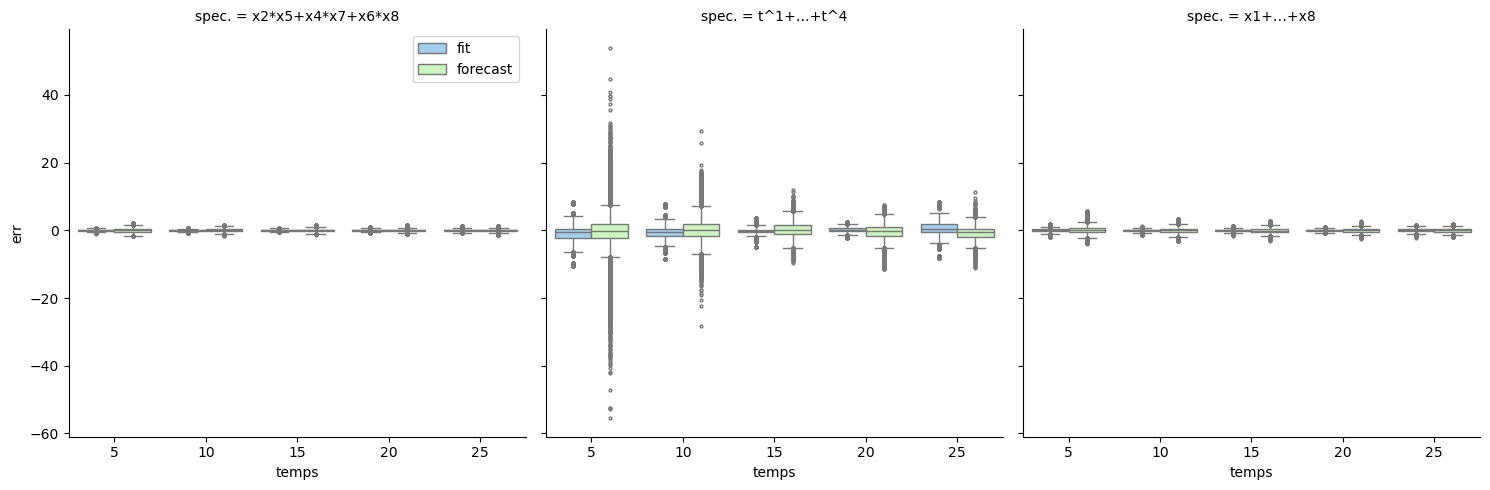

In [186]:
mixed_box_df = box_df[(box_df[DSET] == "test-mixed") & (box_df[MDL] == "Mixed model")].copy()
mixed_box_df["model name"] = mixed_box_df[MDL] + "\n" + mixed_box_df[SPEC]

g = sns.FacetGrid(
    mixed_box_df,
    col=SPEC,
    height=5,
    legend_out=False,
)
g.map_dataframe(
    sns.boxplot,
    x=TSTEPS,
    y="err",
    hue=METD,
    fliersize=2,
    palette=sns.xkcd_palette(["light blue", "pale green"]),
)
g.add_legend()

### Line plots


In [106]:
line_df = comp_df.copy()
line_df = line_df[line_df[INDIV] <= 5]

In [110]:
mixed_line_df[mixed_line_df[MDL] == "Mixed model\nx2*x5+x4*x7+x6*x8"]

,dataset,model,simulation,individus,temps,pred,method,value
0,test-mixed,Mixed model\nx2*x5+x4*x7+x6*x8,simulation1.csv,1,0,-14.825990,fit,-14.147090
1,test-mixed,Mixed model\nx2*x5+x4*x7+x6*x8,simulation1.csv,1,1,-13.545691,fit,-13.233794
2,test-mixed,Mixed model\nx2*x5+x4*x7+x6*x8,simulation1.csv,1,2,-12.922801,fit,-12.791824
3,test-mixed,Mixed model\nx2*x5+x4*x7+x6*x8,simulation1.csv,1,3,-12.592934,fit,-12.532934
4,test-mixed,Mixed model\nx2*x5+x4*x7+x6*x8,simulation1.csv,1,4,-12.406496,fit,-12.371850
...,...,...,...,...,...,...,...,...
10387125,test-mixed,Mixed model\nx2*x5+x4*x7+x6*x8,simulation99.csv,5,21,-0.029490,forecast,-0.050587
10387126,test-mixed,Mixed model\nx2*x5+x4*x7+x6*x8,simulation99.csv,5,22,0.003204,forecast,-0.042950
10387127,test-mixed,Mixed model\nx2*x5+x4*x7+x6*x8,simulation99.csv,5,23,0.005163,forecast,-0.035540
10387128,test-mixed,Mixed model\nx2*x5+x4*x7+x6*x8,simulation99.csv,5,24,-0.102018,forecast,-0.028349


In [107]:
mixed_line_df = line_df[
    (line_df[DSET] == "test-mixed")
    & (line_df[MDL].isin(["Mixed model\nx2*x5+x4*x7+x6*x8", "Mixed model\nx1+…+x8"]))
]

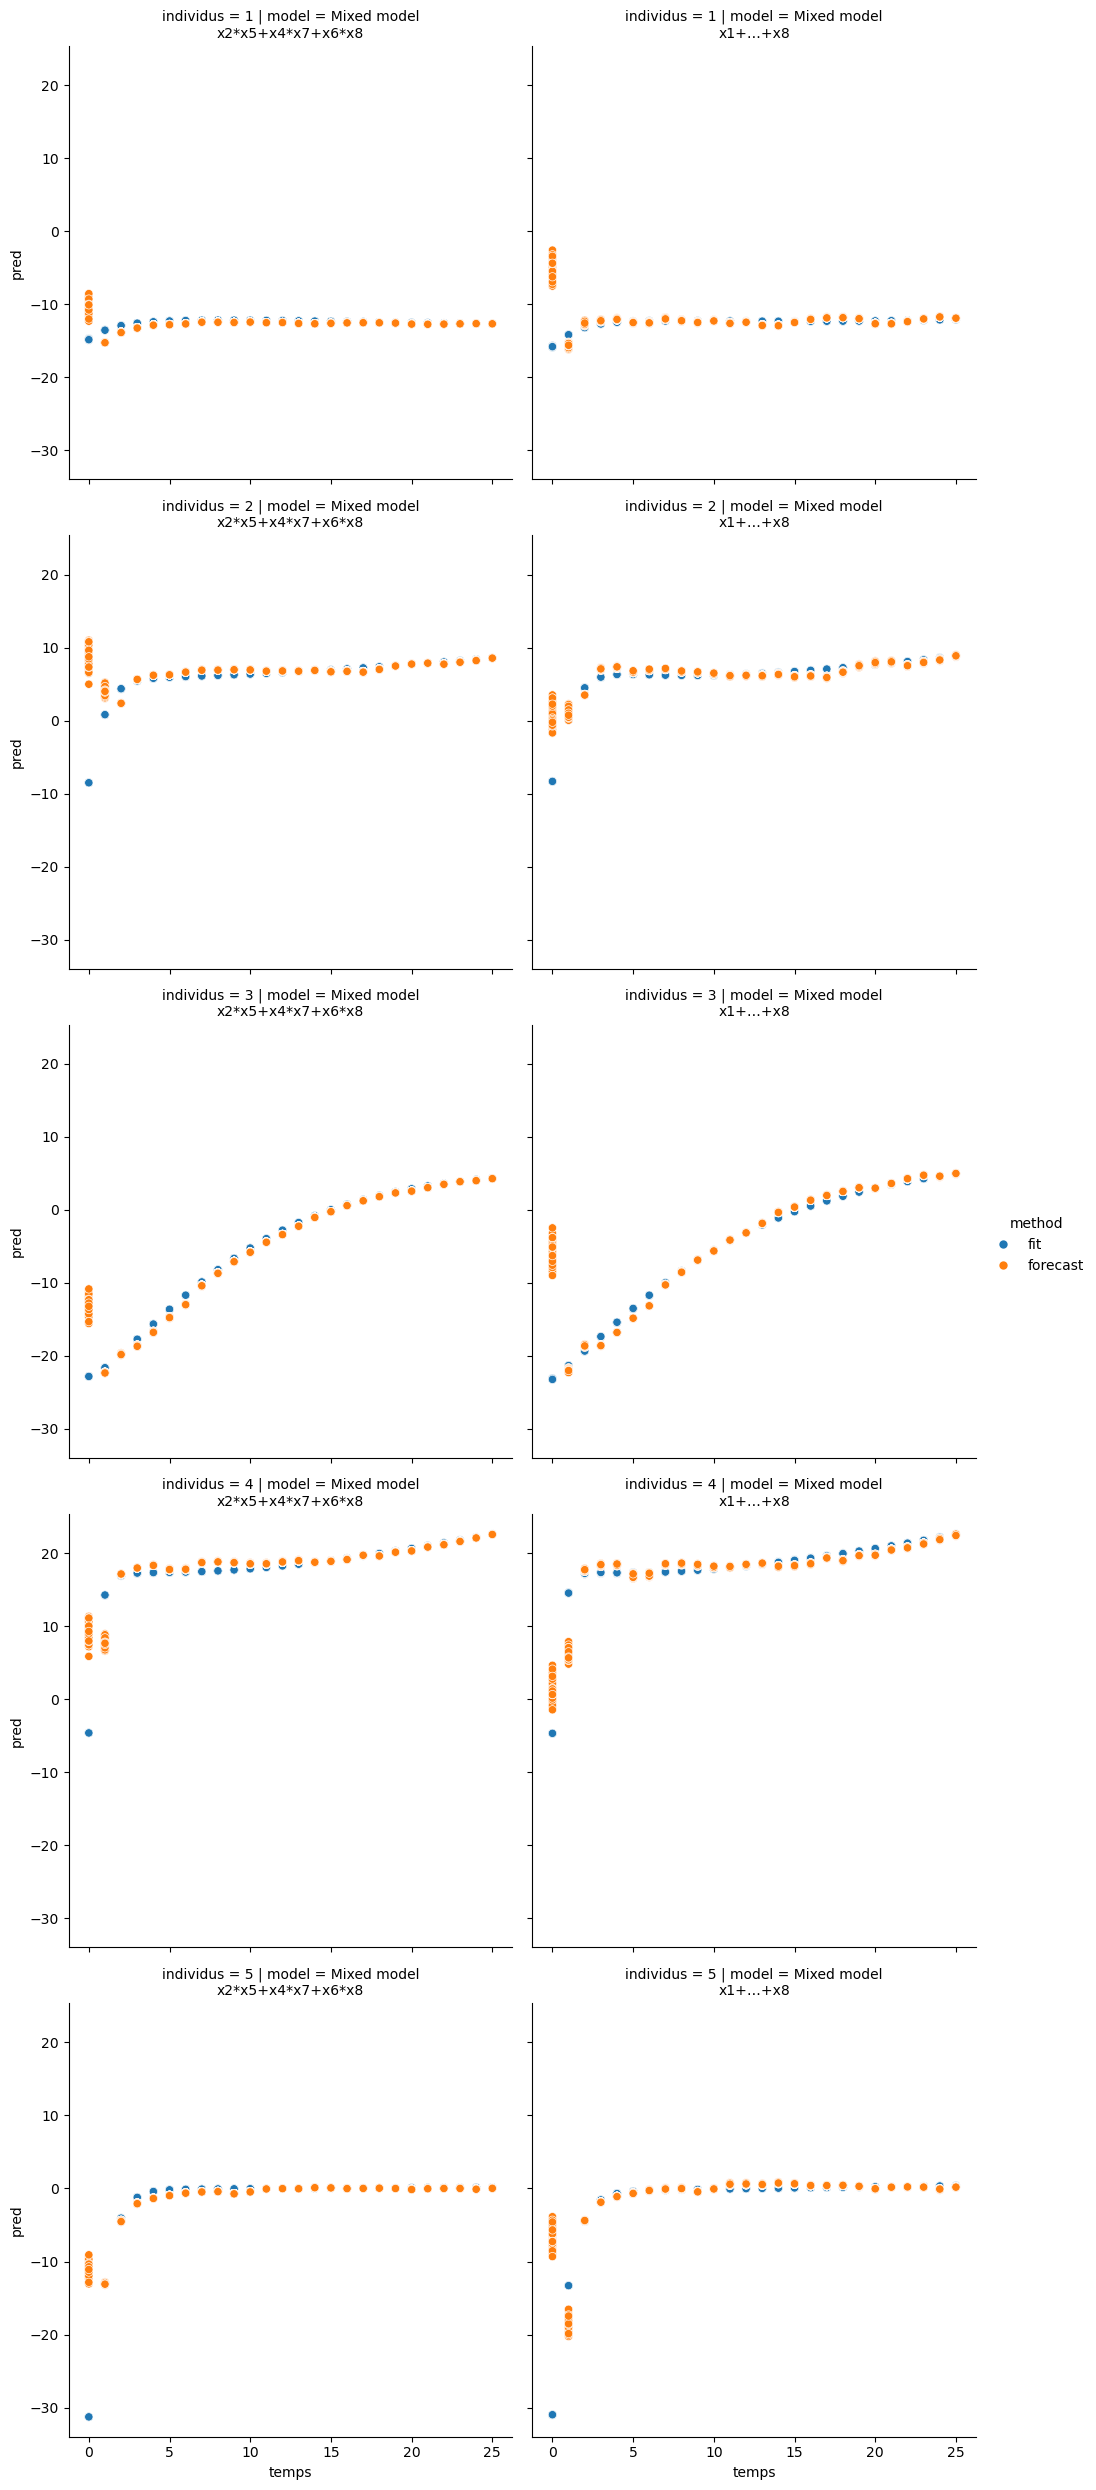

In [109]:
sns.relplot(data=mixed_line_df, row=INDIV, col=MDL, x=TSTEPS, y=PRED, hue=METD)

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, nrows=3)

for irow in range(3):
    for icol in range(3):

        asx[irow, icol] = sns.lineplot(line_df, x=TSTEPS, y=PRED, hue=MDL)

# Updated results (new forecast + reservoirs + mixedml)

## Metrics

In [161]:
df_updated = pd.concat(
    [
        arthur_metrics[arthur_metrics[MDL] == "Linear model"],
        new_metrics,
        reservoir_metrics,
    ]
)

In [163]:
generate_display(df_updated, metric="mse", effect="fixed")

In [164]:
generate_display(df_updated, metric="mse", effect="mixed")

In [ ]:
mrg_df_mixed = mrg_df[
    (mrg_df[DSET] == "test-mixed") & (mrg_df[TSTEPS].isin([5, 10, 15, 20, 25]))
]


g = sns.FacetGrid(mrg_df_mixed, col=MDL, row="sex")
g.map(sns.scatterplot, x=TST, y="err", hue=METD)

# sns.boxplot(mrg_df_mixed, x=MDL, y="err", hue=METD)

## Predictions


In [165]:
df_updated_pred = pd.concat(
    [
        arthur_preds[arthur_preds[MDL] == "Linear model"],
        new_preds,
        reservoir_preds,
    ]
)

KeyError: 'model'